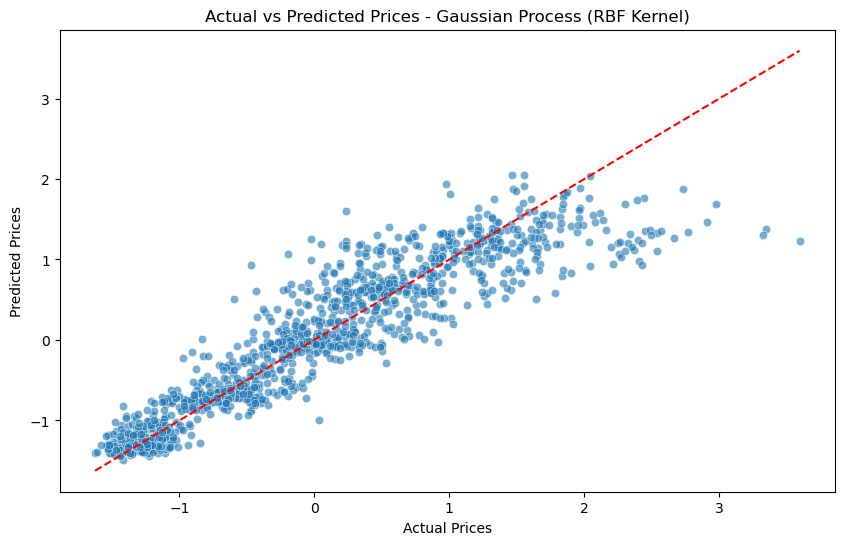

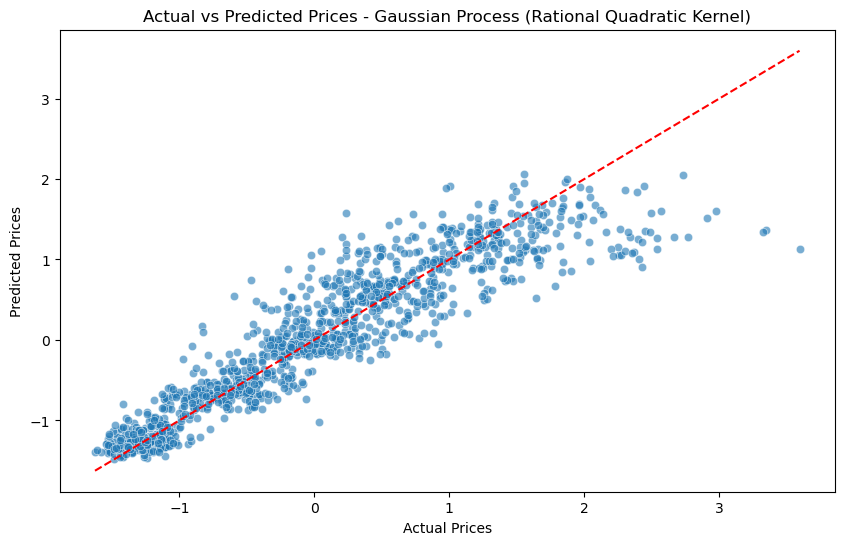

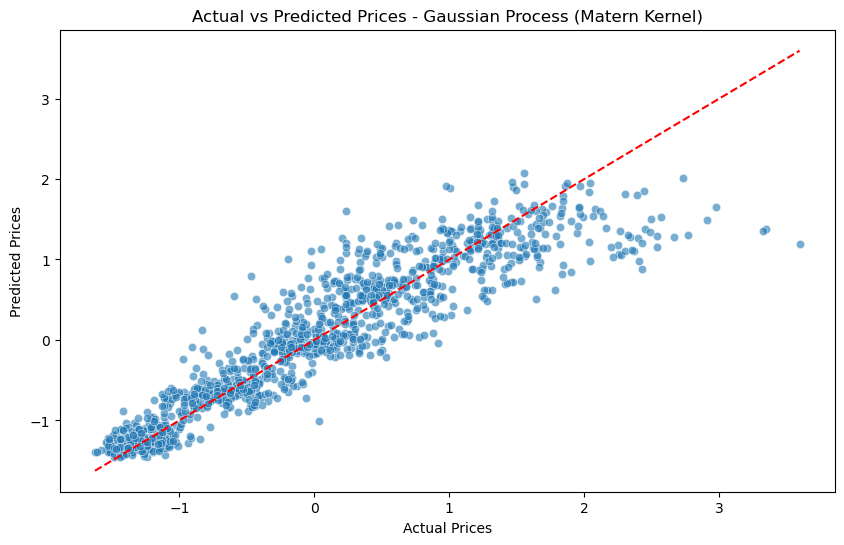

Results for Gaussian Process Regressor with different kernels:
{'Kernel': 'RBF', 'Train R2': 0.8845266951302795, 'Train RMSE': 0.3409599438743523, 'Train MSE': 0.11625368332680146, 'Train MAE': 0.24821604931238464, 'Test R2': 0.8520351605418757, 'Test RMSE': 0.39411957599007263, 'Test MSE': 0.15533024017859462, 'Test MAE': 0.27745849201817385, 'Train Size': 1800, 'Test Size': 1200}
{'Kernel': 'Rational Quadratic', 'Train R2': 0.9164002071006574, 'Train RMSE': 0.2901116465089894, 'Train MSE': 0.08416476744015683, 'Train MAE': 0.2106777798269334, 'Test R2': 0.8596358389425706, 'Test RMSE': 0.3838635367573694, 'Test MSE': 0.14735121485187627, 'Test MAE': 0.26823366388268677, 'Train Size': 1800, 'Test Size': 1200}
{'Kernel': 'Matern', 'Train R2': 0.9105305572114046, 'Train RMSE': 0.3001234494748752, 'Train MSE': 0.09007408492469797, 'Train MAE': 0.21770731812061817, 'Test R2': 0.8591379606473987, 'Test RMSE': 0.38454372515512947, 'Test MSE': 0.14787387655618375, 'Test MAE': 0.2685109877403

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv(r"C:\Users\guymk\expedia_normalized_data_05_07 (1).csv")
df2 = pd.read_csv(r"C:\Users\guymk\expedia_normalized_data_20_06 (1).csv")
df3 = pd.read_csv(r"C:\Users\guymk\expedia_normalized_data_25_06 (1).csv")

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)

# Function to run Gaussian Process Regressor and calculate metrics
def run_gaussian_process_regressor(df, kernel, kernel_name):
    columns_to_use = ['TTT', 'LOS', 'score',
                      'reviews', 'full_price',
                      'Free_cancellation', 'No_payment', 'Breakfast', 'Option Member',
                      'star_rating', 'location_rating',
                      'km_from_center']
    df = df[columns_to_use]

    # Keep only numeric columns
    df = df.select_dtypes(include=[np.number])
    
    # Remove columns with all NaN values
    df = df.dropna(axis=1, how='all')

    # Remove the price_per_night column if it exists
    if 'price_per_night' in df.columns:
        df = df.drop(columns=['price_per_night']) 
    
    # Ensure there are no remaining NaN values
    imputer = SimpleImputer(strategy='mean')
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Subsample the data if it's too large
    if len(df) > 3000:
        df = df.sample(3000, random_state=42)
    
    # Split the data into train and test sets
    X = df.drop(columns=['full_price'])
    y = df['full_price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    
    # Standardize the features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Initialize Gaussian Process Regressor
    model = GaussianProcessRegressor(kernel=kernel, random_state=42, alpha=1e-1, n_restarts_optimizer=1)
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    train_r2 = r2_score(y_train, y_train_pred)
    train_rmse = mean_squared_error(y_train, y_train_pred, squared=False)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    
    # Test metrics
    test_r2 = r2_score(y_test, y_test_pred)
    test_rmse = mean_squared_error(y_test, y_test_pred, squared=False)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    
    results = {
        'Kernel': kernel_name,
        'Train R2': train_r2,
        'Train RMSE': train_rmse,
        'Train MSE': train_mse,
        'Train MAE': train_mae,
        'Test R2': test_r2,
        'Test RMSE': test_rmse,
        'Test MSE': test_mse,
        'Test MAE': test_mae,
        'Train Size': len(X_train),
        'Test Size': len(X_test)
    }
    
    return results, y_test, y_test_pred

# Define kernels
kernels = {
    'RBF': RBF(),
    'Rational Quadratic': RationalQuadratic(),
    'Matern': Matern()
}

# Run Gaussian Process Regressor with different kernels and store results
all_results = []
for kernel_name, kernel in kernels.items():
    results, y_test, y_test_pred = run_gaussian_process_regressor(df, kernel, kernel_name)
    all_results.append(results)
    
    # Plot actual vs predicted prices
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.6)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Actual vs Predicted Prices - Gaussian Process ({kernel_name} Kernel)')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.show()

# Display results
print("Results for Gaussian Process Regressor with different kernels:")
for res in all_results:
    print(res)


## Summary

The Gaussian Process Regressor (GPR) was applied to predict hotel prices using a dataset compiled from three different sources. The dataset included features such as Time to Travel (TTT), Length of Stay (LOS), hotel score, number of reviews, full price, free cancellation, no payment, breakfast inclusion, membership option, star rating, location rating, and distance from the city center.

The data preprocessing steps included:

Merging the datasets.

Selecting relevant numeric columns.

Handling missing values using mean imputation.

Standardizing the features.

Splitting the data into training and test sets.

Three different kernels were tested with the GPR model: Radial Basis Function (RBF), Rational Quadratic, and Matern. The models were evaluated based on their performance metrics: R² score, Root Mean Squared Error (RMSE), Mean Squared Error (MSE), and Mean Absolute Error (MAE) for both training and test sets.

## Conclusion

The Gaussian Process Regressor using the Rational Quadratic kernel achieved the best performance on the test data, with an R² score of 0.860 and relatively lower RMSE and MAE values compared to the other kernels. The model using the Rational Quadratic kernel also demonstrated strong performance on the training data, indicating that it captures the underlying patterns well.